In [1]:
#マルチコプタシミュレーション暫定版
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
"""
def rk4(func, t, h, x, *p)
4次のルンゲ・クッタ法を一回分計算する関数
    引数リスト
    func:導関数
    t：現在時刻を表す変数
    h：刻み幅
    x：出力変数（求めたい値）
    *p:引数の数が可変する事に対応する、その他の必要変数
※この関数では時刻は更新されないため、これとは別に時間更新をする必要があります。

導関数の書き方
def func(t, x, *state):
    func:自分で好きな関数名をつけられます
    t:時刻変数(変数の文字はtで無くても良い) 
    x:出力変数(変数の文字はxで無くても良い)
    *state:その他の必要変数(引数の数は可変可能))
#関数サンプル
def vdot(t, x, *state):
    s1=state[0]
    s2=state[1]
    return t+x+s1+s2
    
"""

def rk4(func, t, h, x, *p):
    #print(x,p)
    k1=h*func(t, x, *p)
    k2=h*func(t+0.5*h, x+0.5*k1, *p)
    k3=h*func(t+0.5*h, x+0.5*k2, *p) 
    k4=h*func(t+h, x+k3, *p)
    x=x+(k1 + 2*k2 + 2*k3 + k4)/6
    return x


In [3]:
def euler2dcm(euler):
    phi=euler[0]
    theta=euler[1]
    psi=euler[2]
    
    e11= np.cos(theta)*np.cos(psi)
    e12= np.cos(theta)*np.sin(psi)
    e13=-np.sin(theta)
    
    e21= np.sin(phi)*np.sin(theta)*np.cos(psi) - np.cos(phi)*np.sin(psi)
    e22= np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi)
    e23= np.sin(phi)*np.cos(theta)
    
    e31= np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(phi)*np.sin(psi)
    e32= np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi)
    e33= np.cos(phi)*np.cos(theta)
    
    return((e11,e12,e13),(e21,e22,e23),(e31,e32,e33))

def dcm2euler(e):
    phi=np.arctan2(e[1][2], e[2][2])
    theta=np.arctan2(-e[0][2], np.sqrt(e[1][2]**2 + e[2][2]**2))
    psi=np.arctan2(e[0][1], e[0][0])
    
    return (phi, theta, psi)

def quat2dcm(q):
    q1=q[0]
    q2=q[1]
    q3=q[2]
    q4=q[3]
    
    e11=   q1**2 - q2**2 - q3**2 + q4**2
    e12= 2 * (q1*q2 + q3*q4)
    e13= 2 * (q1*q3 - q2*q4)
    
    e21= 2 * (q1*q2 - q3*q4)
    e22= - q1**2 + q2**2 - q3**2 + q4**2
    e23= 2 * (q2*q3 + q1*q4)
    
    e31= 2 * (q1*q3 + q2*q4)
    e32= 2 * (q2*q3 - q1*q4)
    e33= - q1**2 - q2**2 + q3**2 + q4**2
    
    return((e11,e12,e13),(e21,e22,e23),(e31,e32,e33))

def dcm2quat(e):
    e11=e[0][0]
    e12=e[0][1]
    e13=e[0][2]
    e21=e[1][0]
    e22=e[1][1]
    e23=e[1][2]
    e31=e[2][0]
    e32=e[2][1]
    e33=e[2][2]
    
    q1=0.5*np.sqrt(1 + e11 - e22 - e33)
    q2=0.5*np.sqrt(1 - e11 + e22 - e33)
    q3=0.5*np.sqrt(1 - e11 - e22 + e33)
    q4=0.5*np.sqrt(1 + e11 + e22 + e33)
    
    q=[q1, q2, q3, q4]
    idx=q.index(max(q))
    
    if idx==0:
        q[1]=( e12+e21)/4/q1
        q[2]=( e13+e31)/4/q1
        q[3]=( e23-e32)/4/q1
    elif idx==1:
        q[0]=( e12+e21)/4/q2
        q[2]=( e23+e32)/4/q2
        q[3]=(-e13+e31)/4/q2
    elif idx==2:
        q[0]=( e13+e31)/4/q3
        q[1]=( e23+e32)/4/q3
        q[3]=( e12-e21)/4/q3
    elif idx==3:
        q[0]=( e23-e32)/4/q4
        q[1]=(-e13+e31)/4/q4
        q[2]=( e12+e21)/4/q4

    return q

In [4]:
#マルチコプタの運動クラス
class multicopter:
    
    grav=9.80665
    
    def __init__(self,\
                 M=7.1e-1,\
                 Jmot=3.4e-6,\
                 D=0.0,\
                 Qf=0.0,\
                 R=0.12,\
                 K=3.28e-3,\
                 Ct=8.3e-7,\
                 Cq=3.0e-8,\
                 Ix=3.24e-3,\
                 Iy=3.68e-3,\
                 Iz=6.26e-3,\
                 l=0.18):
        
        ###モータのパラメータ
        self.M=M
        self.J=Jmot
        self.D=D
        self.Qf=Qf
        self.R=R
        self.K=K
        self.Ct=Ct
        self.Cq=Cq
        self.Ix=Ix
        self.Iy=Iy
        self.Iz=Iz
        self.l=l
        
    #導関数
    def xdot(self, t, x, u1,u2,u3,u4):
        u=x[0]
        v=x[1]
        w=x[2]
        p=x[3]
        q=x[4]
        r=x[5]
        omega_fr=x[6]
        omega_fl=x[7]
        omega_rr=x[8]
        omega_rl=x[9]
        q1=x[10]
        q2=x[11]
        q3=x[12]
        q4=x[13]
        xe=x[14]
        ye=x[15]
        ze=x[16]
                
        efr=u1
        efl=u2
        err=u3
        erl=u4
        
        DCM=quat2dcm((q1,q2,q3,q4))
        phi, theta, psi=dcm2euler(DCM)
                
        Tfr=self.Ct*omega_fr**2
        Tfl=self.Ct*omega_fl**2
        Trr=self.Ct*omega_rr**2
        Trl=self.Ct*omega_rl**2        
        
        Qfr=self.Cq*omega_fr**2
        Qfl=self.Cq*omega_fl**2
        Qrr=self.Cq*omega_rr**2
        Qrl=self.Cq*omega_rl**2
        
        udot=-self.grav*np.sin(theta) -q*w +r*v
        vdot= self.grav*np.cos(theta)*np.sin(phi) -r*u +p*w
        wdot= self.grav*np.cos(theta)*np.cos(phi) -p*v +p*u +\
                -(Tfr + Tfl + Trr + Trl)/self.M
        
        pdot=(0.5*self.l*(Tfr + Trr - Tfl - Trl ) - (self.Iz -self.Iy)*q*r)/self.Ix
        qdot=(0.5*self.l*(Trr + Trl - Tfr - Tfl ) - (self.Ix -self.Iz)*r*p)/self.Iy
        rdot=((Qfr + Qrl - Qfl - Qrr ) - (self.Iy -self.Ix)*p*q)/self.Iz
        
        omegadot_fr=(self.K/self.R*efr \
                    - (self.D + self.K**2/self.R)*omega_fr\
                    - self.Cq*omega_fr**2\
                    )/self.J
        omegadot_fl=(self.K/self.R*efl \
                    - (self.D + self.K**2/self.R)*omega_fl\
                    - self.Cq*omega_fl**2\
                    )/self.J
        omegadot_rr=(self.K/self.R*err \
                    - (self.D + self.K**2/self.R)*omega_rr\
                    - self.Cq*omega_rr**2\
                    )/self.J
        omegadot_rl=(self.K/self.R*erl \
                    - (self.D + self.K**2/self.R)*omega_rl\
                    - self.Cq*omega_rl**2\
                    )/self.J
        
        q1dot=0.5*( r*q2 -q*q3 +p*q4)
        q2dot=0.5*(-r*q1 +p*q3 +q*q4)
        q3dot=0.5*( q*q1 -p*q2 +r*q4)
        q4dot=0.5*(-p*q1 -q*q2 -r*q3)
        
        xedot=DCM[0][0]*u + DCM[1][0]*v + DCM[2][0]*w
        yedot=DCM[0][1]*u + DCM[1][1]*v + DCM[2][1]*w
        zedot=DCM[0][2]*u + DCM[1][2]*v + DCM[2][2]*w
        
        return np.array([udot, vdot, wdot,\
                    pdot, qdot, rdot,\
                    omegadot_fr, omegadot_fl, omegadot_rr, omegadot_rl,\
                    q1dot, q2dot, q3dot, q4dot,\
                    xedot, yedot, zedot])
    

    

  0%|          | 0/10000 [00:00<?, ?it/s]

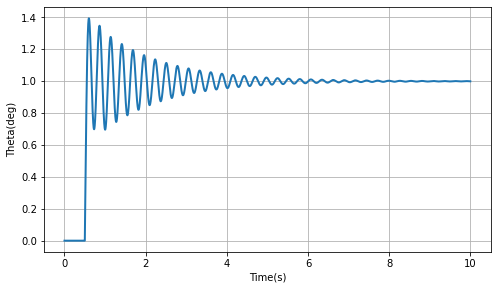

In [52]:
#ここからメイン
copter=multicopter()

#刻み幅
h=0.001

#各状態初期化
t=0.0
dcm=euler2dcm((0.0,0.0,0.0))
q1,q2,q3,q4=dcm2quat(dcm)
u=v=w=0.0
p=q=r=0.0
omega_fr=omega_fl=omega_rr=omega_rl=0.0
xe=ye=ze=0
x=np.array([u,v,w,\
            p,q,r,\
            omega_fr,omega_fl,omega_rr,omega_rl,
            q1,q2,q3,q4,
            xe,ye,ze])

#ホバリング状態の入力
e0=(copter.D*copter.R+copter.K**2)/2/copter.K*np.sqrt(copter.grav*copter.M/copter.Ct)\
    + copter.Cq*copter.R*copter.M*copter.grav/4/copter.K/copter.Ct\
    + copter.R*copter.Qf/copter.K

#入力の初期値
u1=e0+1
u2=e0+1
u3=e0+1
u4=e0+1

#シミュレーション時間
fintime=10.0

#制御開始時間
start_control_time=0.5

T=[]
X=[]
out=[[],[],[],[],[],\
   [],[],[],[],[],\
   [],[],[],[],[],\
   [],[],[],[],[],\
   []]

#ピッチ角速度制御PIDゲイン
Kqp= 3.8042
Tqi= 0.1
Tqd= 0.0111

#ピッチ角速度積分器
Sq=0
#ピッチ角速度誤差
eq=0

#ピッチ角度制御PIDゲイン(y軸周り)
#Kyp= 25.9369
#Tyi=  0.0700
#Tyd=  0.0352
Kyp= 25.9369
Tyi=  0.0700
Tyd=  0.0352
#ピッチ角度積分器
Sy=0
#ピッチ角度誤差
ey=0

theta=0
flag=False

for _ in tqdm(range(int(fintime/h))):
    T.append(t)
    X.append(x)
    q1=x[10]
    q2=x[11]
    q3=x[12]
    q4=x[13]
    
    
    #制御
    if t>=start_control_time:
        if flag==False:
            flag=True
            ry=1*np.pi/180
        oldey=ey
        DCM=quat2dcm((q1,q2,q3,q4))
        phi, theta, psi=dcm2euler(DCM)
        ey=ry-theta
        Sy=Sy+ey*h
        uy=Kyp*(ey + Tyd*(ey-oldey)/h + Sy/Tyi)  
        #print(uy)
        
        oldeq=eq
        eq=uy-x[4]
        Sq=Sq+eq*h
        uq=Kqp*(eq + Tqd*(eq-oldeq)/h + Sq/Tqi)  

        u1=(e0-uq)/4
        u2=(e0-uq)/4
        u3=(e0+uq)/4
        u4=(e0+uq)/4
    
    x=rk4(copter.xdot, t, h, x, u1, u2, u3, u4)
    t=t+h

T.append(t)
X.append(x)

for x in X:
    for i in range(len(x)):
        out[i].append(x[i])

PHI=[]
THETA=[]
PSI=[]
for q1,q2,q3,q4 in zip(out[10],out[11],out[12],out[13]):
    DCM=quat2dcm((q1,q2,q3,q4))
    phi, theta, psi=dcm2euler(DCM)
    PHI.append(phi)
    THETA.append(theta)
    PSI.append(psi)
    
T=np.array(T)
plt.figure(figsize=(8,4.5))
plt.plot(T,np.array(THETA)*180/np.pi,lw=2)
plt.xlabel('Time(s)')
#plt.ylabel('Pitch Rate(rad/s)')
plt.ylabel('Theta(deg)')
plt.grid()
plt.show()
